<a href="https://colab.research.google.com/github/nmf0920/DeepLearningLab/blob/main/Deep_Learning_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Convolutional Networks

#Overall Tasks

(See if you can get to Step 3 in the lab itself in case you have questions since the last steps are really calculations and experimenting with the notebook ...)

1. It might be good to first read through all this code to get a general idea of the workflow that we will follow.

2. Then create the network architecture for a dense MLP (multi-layer perceptron) and a Conv2D network model as given in the Notebook cell below. (You may want to look at the PyTorch documentation for this.)

3. Following the Notebook downward - then train each of these models. Run
the test data through to see how the models got on. Compare the perfomance of Linear dense model and Conv2D model.

4. Can you work out the number of parameters in your dense MLP network and your Conv2D network? Which one is more likely to overfit?

5. Use this notebook to experiment with different numbers and sizes of layers and kernel sizes. Note the distinction between the loss (the function we optimise) and accuracy (the actual performance we care about)!

6. See how using ADAM to optimise changes learning behaviour compared to SGD.


---


This week we will get some hands-on experience with convolutional networks on 2D images.

After this lab, you should:

*   Understand how to build and train a convolutional neural network in PyTorch
*   Know how to change the numbers and parameters of layers
*   Have a point of comparison for the relative performance of fully connected vs. convolutional networks on a realistic dataset

This is quite a challenging lab where **you will have to look up the PyTorch documentation for different classes** (and last week's lab) to write PyTorch models yourself.

Again make sure you read through the code and try to work out how it is working. (There will be quite a few unfamiliar things introduced in this lab ... but you will get more used to these as the weeks go on.)

First, we will set up a few things:

**(IMPORTANT - read through the code! In particular note the comment that says that you should set your runtime on Colab to use a GPU !)**

In [1]:
from google.colab import files

# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "pytorch"

# make sure you use the GPU (btw check your runtime is a GPU in colab)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    files.download(PROJECT_ROOT_DIR+'/images/'+CHAPTER_ID+'/'+fig_id + ".png")

print("Using CUDA ? " + str(use_cuda))

Using CUDA ? True


Now you need to define the network properties.

Fill in the missing structure to implement:

 1. A multi-layer linear, dense network for `model_dense`
 2. A multi-layer convolutional network for `model`.

You should know how to build the dense architecture from the last two weeks. Note we suggest the use of the `nn.Sequential` object, the use of an `OrderedDict` structure will allow you to name each layer, for clearer display when you print your model.  

For the convnet, remember that the output of every `Conv2d` and `MaxPool2d` layer is a 3D tensor of shape *(channels, height, width)*. The *width* and *height* dimensions tend to shrink as we go deeper in the network (you can use the `padding` parameter to counteract this). The number of input channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64) and the number of kernels / output channels / feature maps is controlled by the second number. Remember to check the impact of padding parameters and maxpooling output dimensions when structuring the dimensions of the conv2d layers.

The next step would be to feed our last output tensor (of shape (N, X, Y)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D (you can use `nn.Flatten` for this), and then add a few Dense layers after that (be careful to set the correct number of inputs for the dense layers, some calculations by hand are required here!).

We are going to do 10-way classification, so use a final layer with 10 outputs and if you want probabilities out, you can use a `nn.Softmax` activation. (Note that if your cost function is [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) you should not use softmax for the output - the CrossEntropyLoss includes it internally!).

I would suggest to start with *small* models: it will make the training faster. You can always push a bit the parameters for your last experiments at the end.

In [2]:
import collections

model_dense = nn.Sequential(collections.OrderedDict([

    # You need to fill this in to create a fully connected network.
    ('flatten',nn.Flatten()),
    ('fc1', nn.Linear(784, 128)),
    ('relu1', nn.ReLU()),
    ('fc22', nn.Linear(128, 64)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(64, 10)),
        ]))

model = nn.Sequential(collections.OrderedDict([

    # You need to fill this in to create a convolutional network.
    ('conv1', nn.Conv2d(1, 32, kernel_size=3, padding=1)),# 输入通道1，输出通道32的卷积层
    ('relu1', nn.ReLU()),
    ('maxpool1', nn.MaxPool2d(kernel_size=2, stride=2)),
    ('conv2', nn.Conv2d(32, 64, kernel_size=3, padding=1)),  # 输入通道32，输出通道64的卷积层
    ('relu2', nn.ReLU()),
    ('maxpool2', nn.MaxPool2d(kernel_size=2, stride=2)),

    # Add more conv layers if needed
    ('flatten', nn.Flatten()),# 将卷积层输出展平为1D向量
    ('fc1', nn.Linear(64 * 7 * 7, 128)),  # 输入维度为64*7*7，输出128维的全连接层
    ('relu3', nn.ReLU()),
    ('fc2', nn.Linear(128, 10))  # 输出层，10个类别的全连接层，不使用Softmax
]))



Now here's what the architecture of our two networks that you have developed looks like:

In [3]:
print("Dense MLP Model:")
print(model_dense)

print("\nCNN Network Model:")
print(model)

Dense MLP Model:
Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc22): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

CNN Network Model:
Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Now, let's train our ConvNet on the Fashion MNIST digits. You can[ learn more about the Fashion-MNIST data set](https://github.com/zalandoresearch/fashion-mnist).

We specify the root directory to store the dataset, download the training data, if not present on the local machine, and then apply the transforms. ToTensor to turn images into Tensor so we can directly use it with our network. The dataset is stored in the dataset class named `train_set` and the test data in (unsurprisingly) `test_set`.

In [4]:
import torchvision
import torchvision.transforms as transforms

# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)
print(train_set, test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Then we need to define functions for training and testing our networks, the training loop here is fairly standard and is very much the same as in previous weeks.

In [5]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


We then initialise the parameters for the training of our networks: optimiser (Stochastic Gradient Descent here, but you can also try Adam), and data loader to pack your training data in mini-batches.

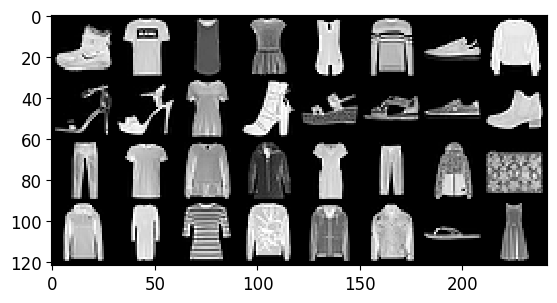

In [6]:
lr = 0.01

# set up a loader object to use minibatches
loader = torch.utils.data.DataLoader(train_set, batch_size = 32)

# also set up a loader for test data, using a single batch
test_loader = torch.utils.data.DataLoader(test_set)

# we set the optimiser as Stochastic Gradient Descent for both networks,
# you could also try Adam
optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer_dense = optim.SGD(model_dense.parameters(), lr=lr)
#optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer_dense = optim.Adam(model_dense.parameters(), lr=lr)

# show the first batch of training data
images, labels = next(iter(loader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

# set the loss function to optimise. Cross Entropy is usually the best for
# classification
loss_fn = nn.CrossEntropyLoss()

Finally, we can call the training loop on both models to see how they train. It is a good idea here to ensure some output in your training function so that you get a feeling how fast (and how well) the training goes and that you can abort a training that would be unreasonably long...

You could also use `tensorboard` for this purpose, but it is a bit messier to set up, so we will only use printouts at this stage.

(https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)

In [7]:

# set the number of epochs: The number of time that the whole training set
# will be seen by the network during training
n_epochs = 2 # see how sensitive results are to this


# train the CNN
training_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)


# train the dense model
training_loop(
    n_epochs = n_epochs,
    optimizer = optimizer_dense,
    model = model_dense,
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)



2024-03-14 15:27:08.732916 Epoch 1, Training loss 1715.0845613777637
2024-03-14 15:27:20.918577 Epoch 2, Training loss 1017.813394293189
2024-03-14 15:27:34.681359 Epoch 1, Training loss 1956.5366931557655
2024-03-14 15:27:45.210914 Epoch 2, Training loss 1093.5714028179646


We can then run the test loop using the two different models to assess performance.

In [8]:

test_loop(model = model, device = device, test_loader = test_loader)
test_loop(model = model_dense, device = device, test_loader = test_loader)


Test set: Average loss: 0.5082, Accuracy: 8118/10000 (81%)


Test set: Average loss: 0.5559, Accuracy: 8061/10000 (81%)



How well did your two models do for this task ?

For "similar sized" networks - you should find the CNN network outperforms a fully connected one.

Also - when the fully connected one has vastly more parameters (as described in the lecture) - you should find that it performs poorly on the test data due to overfitting.

Try experimenting with your network architectures and different approaches to optimization (does SGD or Adam optimize better in this case?) What happens if you set the learning rate ("lr") to a very high value? What happens if you set it to a very low value?